<a href="https://colab.research.google.com/github/kriskalb/laptop-price-prediction/blob/main/project_regression_laptops_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [598]:
!pip install optuna
!pip install xgboost
!pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import optuna
import xgboost
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
import pyarrow.parquet as pq
from sklearn.model_selection import GridSearchCV

In [600]:
from google.colab import drive

# Mounting Google Drive and importing a csv file from the drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Kurs/project_regression/laptop_price.csv'
df = pd.read_csv(path, encoding = 'ISO-8859-1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [601]:
# import laptop_price.csv to df (Jupiter Notebook)
# df = pd.read_csv('laptop_price.csv', encoding = 'ISO-8859-1')
# df.info()

In [602]:
df_copy = df.copy()

# Preliminary analysis

In [603]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [604]:
len(list(df.laptop_ID.unique()))

1303

In [605]:
df.laptop_ID.count()

1303

In [606]:
df.set_index('laptop_ID', inplace=True)

In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [608]:
# change type from object to category - chosen columns
for col in ['Company', 'Product', 'TypeName','ScreenResolution', 'Cpu','Ram', 'Memory', 'Gpu', 'OpSys']:
  df[col]=df[col].astype('category')

In [609]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Inches,1303.0,15.017191,1.426304,10.1,14.0,15.6,15.60,18.4
Price_euros,1303.0,1123.686992,699.009043,174.0,599.0,977.0,1487.88,6099.0


In [610]:
df.describe(include=['category']).T

,count,unique,top,freq
Company,1303,19,Dell,297
Product,1303,618,XPS 13,30
TypeName,1303,6,Notebook,727
ScreenResolution,1303,40,Full HD 1920x1080,507
Cpu,1303,118,Intel Core i5 7200U 2.5GHz,190
Ram,1303,9,8GB,619
Memory,1303,39,256GB SSD,412
Gpu,1303,110,Intel HD Graphics 620,281
OpSys,1303,9,Windows 10,1072


In [611]:
df.isna().sum()

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

# Preliminary visualization

<Axes: >

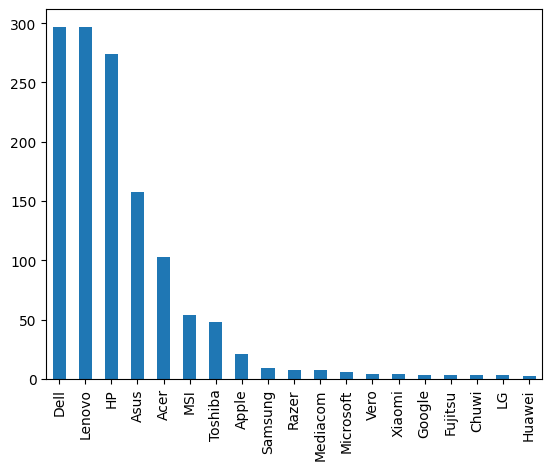

In [612]:
df['Company'].value_counts().plot(kind='bar')

<Axes: >

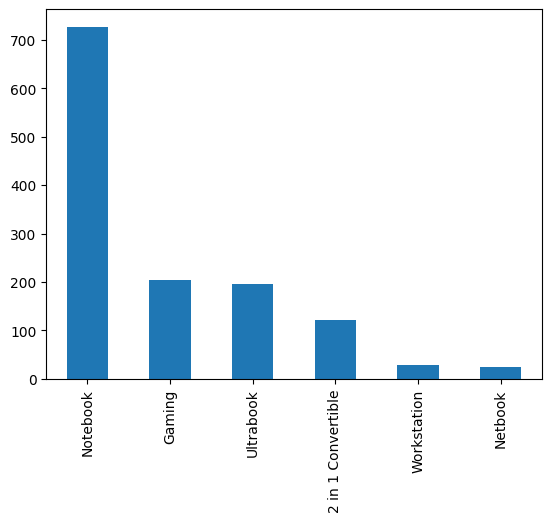

In [613]:
df['TypeName'].value_counts().plot(kind='bar')

<Axes: >

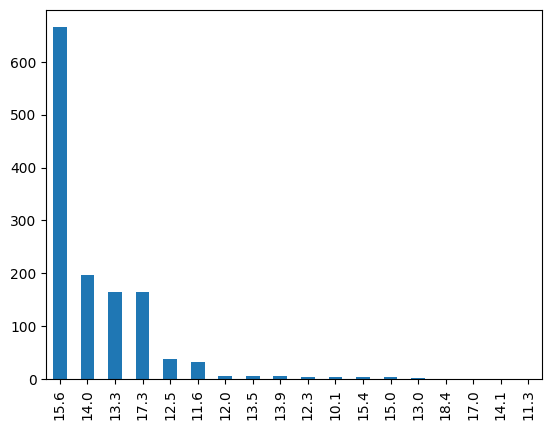

In [614]:
df['Inches'].value_counts().plot(kind='bar')

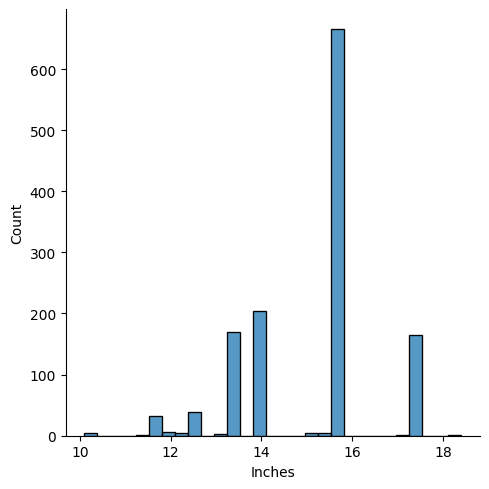

In [615]:
sns.displot(df['Inches'])

<Axes: >

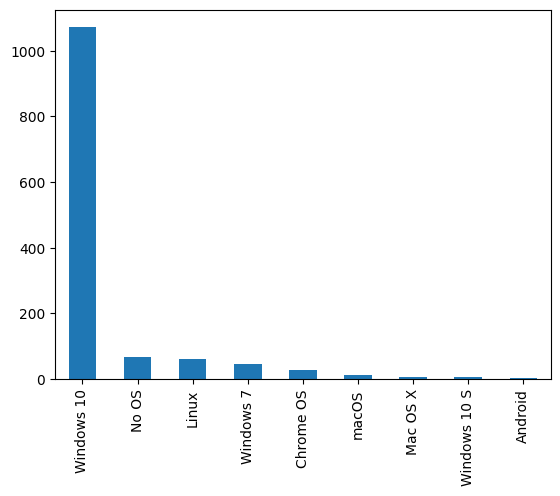

In [616]:
df['OpSys'].value_counts().plot(kind='bar')

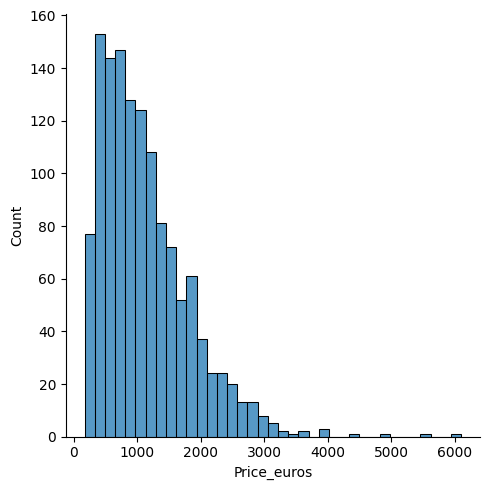

In [617]:
sns.displot(df['Price_euros'])
plt.show()

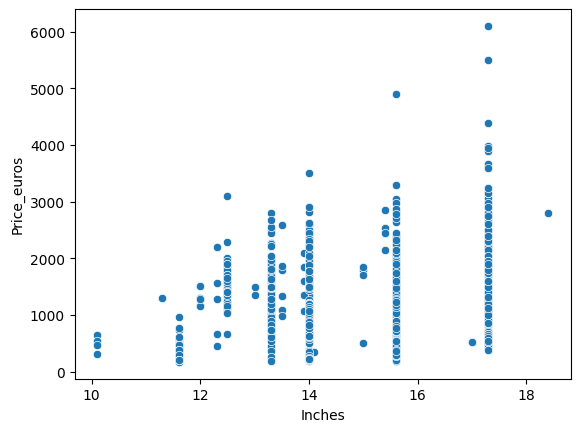

In [618]:
sns.scatterplot(x=df['Inches'],y=df['Price_euros'])
plt.show()

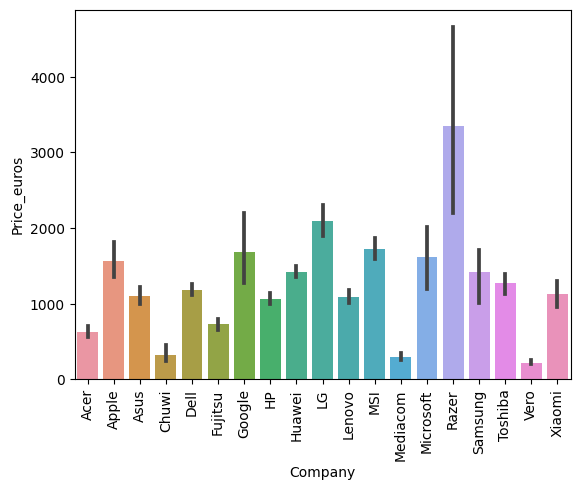

In [619]:
sns.barplot(x=df['Company'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

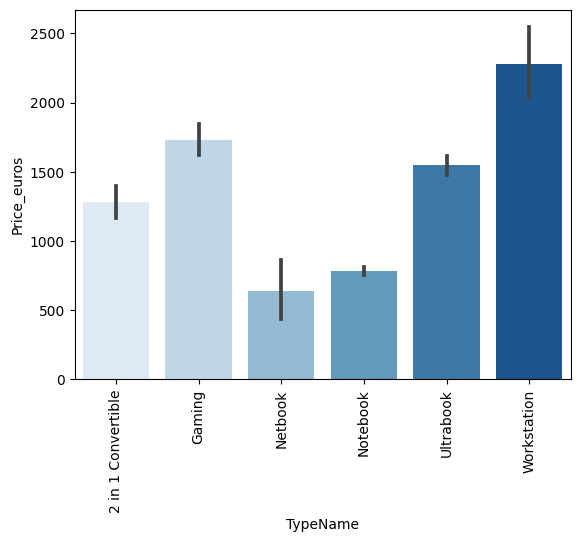

In [620]:
sns.barplot(x=df['TypeName'],y=df['Price_euros'], palette='Blues')
plt.xticks(rotation='vertical')
plt.show()

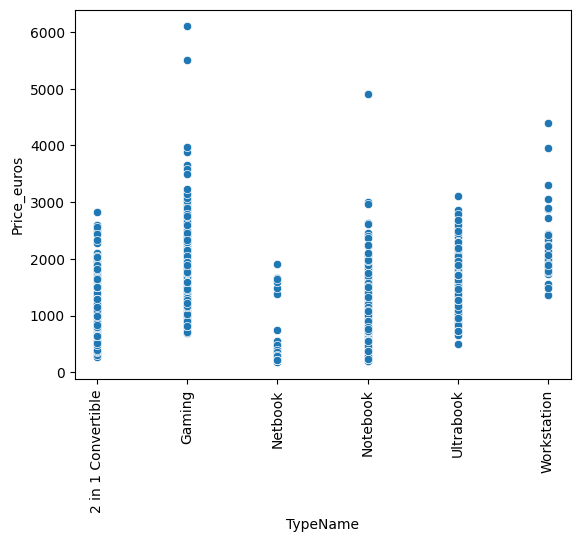

In [621]:
sns.scatterplot(x=df['TypeName'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

# Data processing

Processing the ScreenResolution column

In [622]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
Touchscreen 2560x1440                              7
4K Ultra HD 3840x2160                              7
IPS Panel 1366x768                                 7
Touchscreen 2256x1504                              6
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Touchscreen 2560x1440               

In [623]:
#separating numbers from letters
regex_to_separate = r'^(?P<name>.*?)(?P<resolution>\d+x\d+)?$'

# rozdzielenie do nowych kolumn
df[['NameResolution', 'Resolution']] = df['ScreenResolution'].str.extract(regex_to_separate)

In [624]:
df['Resolution'].unique()

array(['2560x1600', '1440x900', '1920x1080', '2880x1800', '1366x768',
       '2304x1440', '3200x1800', '1920x1200', '2256x1504', '3840x2160',
       '2160x1440', '2560x1440', '1600x900', '2736x1824', '2400x1600'],
      dtype=object)

In [625]:
df['Resolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: Resolution, dtype: int64

In [626]:
# mapping function for division into resolution classes, separation of divisions
def split_to_class(resolution):
    width, height = map(int, resolution.split('x'))
    if width >= 3840 and height >= 2160:
        return '4K UHD'
    elif width >= 2560 and height >= 1440:
        return 'QHD'
    elif width >= 1920 and height >= 1080:
        return 'Full HD'
    else:
        return 'HD'

df['Class_Resolution'] = df['Resolution'].apply(split_to_class)

In [627]:
df.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution
laptop_ID,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,IPS Panel Retina Display,2560x1600,QHD
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,,1440x900,HD
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,Full HD,1920x1080,Full HD
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,IPS Panel Retina Display,2880x1800,QHD
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,IPS Panel Retina Display,2560x1600,QHD


In [628]:
df = pd.get_dummies(data=df, drop_first=True, columns=['Class_Resolution'])

In [629]:
df.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution_Full HD,Class_Resolution_HD,Class_Resolution_QHD
laptop_ID,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,IPS Panel Retina Display,2560x1600,0,0,1
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,,1440x900,0,1,0
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,Full HD,1920x1080,1,0,0
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,IPS Panel Retina Display,2880x1800,0,0,1
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,IPS Panel Retina Display,2560x1600,0,0,1


In [630]:
df.Memory.unique()

['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD', '500GB HDD', ..., '8GB SSD', '508GB Hybrid', '1.0TB HDD', '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid']
Length: 39
Categories (39, object): ['1.0TB HDD', '1.0TB Hybrid', '128GB Flash Storage', '128GB HDD', ...,
                          '64GB Flash Storage', '64GB Flash Storage +  1TB HDD', '64GB SSD', '8GB SSD']

Clearing the 'Memory' column and creating 'Memory_Size', 'Memory_Size_added', 'Memory_Type' based on it

In [631]:
df[['Memory_Size', 'Memory_Type']] = df['Memory'].str.split(' ', 1, expand=True)

In [632]:
df.Memory_Type.unique()

array(['SSD', 'Flash Storage', 'HDD', 'SSD +  1TB HDD',
       'SSD +  256GB SSD', 'SSD +  2TB HDD', 'Hybrid', 'SSD +  500GB HDD',
       'SSD +  512GB SSD', 'Flash Storage +  1TB HDD', 'HDD +  1TB HDD',
       'SSD +  1.0TB Hybrid'], dtype=object)

In [633]:
df['Memory_Size_added'] = df['Memory_Type'].copy()

In [634]:
df.loc[~(df['Memory_Type'].str.contains('\+')), 'Memory_Size_added'] = '0'
df.loc[(df['Memory_Type'].str.contains('\+')), 'Memory_Size_added'] = df.loc[(df['Memory_Type'].str.contains('\+')), 'Memory_Size_added'].str.split().apply(lambda x: x[-2])
df.loc[df['Memory_Size_added']=='1TB', 'Memory_Size_added'] = '1000GB'
df.loc[df['Memory_Size_added']=='2TB', 'Memory_Size_added'] = '2000GB'
df.loc[df['Memory_Size_added']=='1.0TB', 'Memory_Size_added'] = '1000GB'
df['Memory_Size_added'] = df['Memory_Size_added'].str.replace('[a-zA-Z]', '', regex=True).astype(float)

In [635]:
df.Memory_Size_added.unique()

array([   0., 1000.,  256., 2000.,  500.,  512.])

In [636]:
df.Memory_Size.unique()

array(['128GB', '256GB', '512GB', '500GB', '1TB', '32GB', '64GB', '2TB',
       '1.0TB', '16GB', '180GB', '240GB', '8GB', '508GB'], dtype=object)

In [637]:
df.loc[df['Memory_Size']=='1TB', 'Memory_Size'] = '1000GB'
df.loc[df['Memory_Size']=='2TB', 'Memory_Size'] = '2000GB'
df.loc[df['Memory_Size']=='1.0TB', 'Memory_Size'] = '1000GB'
df['Memory_Size'] = df['Memory_Size'].str.replace('[a-zA-Z]', '', regex=True).astype(float)


In [638]:
df.Memory_Size.unique()

array([ 128.,  256.,  512.,  500., 1000.,   32.,   64., 2000.,   16.,
        180.,  240.,    8.,  508.])

In [639]:
df['Memory_Type'].unique()

array(['SSD', 'Flash Storage', 'HDD', 'SSD +  1TB HDD',
       'SSD +  256GB SSD', 'SSD +  2TB HDD', 'Hybrid', 'SSD +  500GB HDD',
       'SSD +  512GB SSD', 'Flash Storage +  1TB HDD', 'HDD +  1TB HDD',
       'SSD +  1.0TB Hybrid'], dtype=object)

In [640]:
df.loc[df['Memory_Type'].str.startswith('SSD') & df['Memory_Type'].str.endswith('SSD'), 'Memory_Type'] = 'SSD'
df.loc[df['Memory_Type'].str.startswith('SSD') & df['Memory_Type'].str.endswith('HDD'), 'Memory_Type'] = 'SSD + HDD'
df.loc[df['Memory_Type'].str.startswith('Flash Storage') & df['Memory_Type'].str.endswith('HDD'), 'Memory_Type'] = 'SSD + HDD'
df.loc[df['Memory_Type'].str.startswith('HDD') & df['Memory_Type'].str.endswith('HDD'), 'Memory_Type'] = 'HDD'
df.loc[df['Memory_Type'].str.startswith('SSD') & df['Memory_Type'].str.endswith('Hybrid'), 'Memory_Type'] = 'SSD + HDD'
df.loc[df['Memory_Type']=='Flash Storage', 'Memory_Type'] = 'SSD'
df.loc[df['Memory_Type']=='Hybrid', 'Memory_Type'] = 'HDD'


In [641]:
df['Memory_Type'].unique()

array(['SSD', 'HDD', 'SSD + HDD'], dtype=object)

In [642]:
df['Memory_Type_num'] = df['Memory_Type'].copy()

In [643]:
memory_types = {
    'HDD': 1,
    'SSD + HDD': 2,
    'SSD': 3,
}

# Zamiana wartości w kolumnie na numeryczne z użyciem mapowania
df['Memory_Type_num'] = df['Memory_Type_num'].map(memory_types)

In [644]:
df['Memory_Type_num'].unique()

array([3, 1, 2])

Clearing the 'GPU' column and creating 'GPU_producer' from it

In [645]:
len(list(df.Gpu.unique()))

110

In [646]:
len(list(df.Cpu.unique()))

118

In [647]:
df.Gpu.unique()

['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000', 'Intel HD Graphics 620', 'AMD Radeon Pro 455', 'Intel Iris Plus Graphics 650', ..., 'Nvidia Quadro M500M', 'AMD Radeon R7 M360', 'Nvidia Quadro M3000M', 'Nvidia GeForce 960M', 'ARM Mali T860 MP4']
Length: 110
Categories (110, object): ['AMD FirePro W4190M', 'AMD FirePro W4190M ', 'AMD FirePro W5130M',
                           'AMD FirePro W6150M', ..., 'Nvidia Quadro M500M', 'Nvidia Quadro M520M',
                           'Nvidia Quadro M620', 'Nvidia Quadro M620M']

In [648]:
df['Gpu_producent']=df['Gpu'].astype(object).copy()

In [649]:
df.loc[df['Gpu_producent'].str.startswith('Intel'), 'Gpu_producent'] = 'Intel'
df.loc[df['Gpu_producent'].str.startswith('AMD'), 'Gpu_producent'] = 'AMD'
df.loc[df['Gpu_producent'].str.startswith('Nvidia'), 'Gpu_producent'] = 'Nvidia'
df.loc[df['Gpu_producent'].str.startswith('ARM'), 'Gpu_producent'] = 'ARM'

In [650]:
df.Gpu_producent.unique()

array(['Intel', 'AMD', 'Nvidia', 'ARM'], dtype=object)

In [651]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

# Wykorzystanie LabelEncoder do zakodowania kolumny 'Gpu_producent'
df['GPU_encoded'] = label_encoder.fit_transform(df['Gpu_producent'])
df.GPU_encoded.unique()

array([2, 0, 3, 1])

In [652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1303 non-null   category
 1   Product                   1303 non-null   category
 2   TypeName                  1303 non-null   category
 3   Inches                    1303 non-null   float64 
 4   ScreenResolution          1303 non-null   category
 5   Cpu                       1303 non-null   category
 6   Ram                       1303 non-null   category
 7   Memory                    1303 non-null   category
 8   Gpu                       1303 non-null   category
 9   OpSys                     1303 non-null   category
 10  Weight                    1303 non-null   object  
 11  Price_euros               1303 non-null   float64 
 12  NameResolution            1303 non-null   object  
 13  Resolution                1303 non-null   object

Clearing the 'Weight' column and changing the column type to float



In [653]:
df.Weight.unique()

array(['1.37kg', '1.34kg', '1.86kg', '1.83kg', '2.1kg', '2.04kg', '1.3kg',
       '1.6kg', '2.2kg', '0.92kg', '1.22kg', '0.98kg', '2.5kg', '1.62kg',
       '1.91kg', '2.3kg', '1.35kg', '1.88kg', '1.89kg', '1.65kg',
       '2.71kg', '1.2kg', '1.44kg', '2.8kg', '2kg', '2.65kg', '2.77kg',
       '3.2kg', '0.69kg', '1.49kg', '2.4kg', '2.13kg', '2.43kg', '1.7kg',
       '1.4kg', '1.8kg', '1.9kg', '3kg', '1.252kg', '2.7kg', '2.02kg',
       '1.63kg', '1.96kg', '1.21kg', '2.45kg', '1.25kg', '1.5kg',
       '2.62kg', '1.38kg', '1.58kg', '1.85kg', '1.23kg', '1.26kg',
       '2.16kg', '2.36kg', '2.05kg', '1.32kg', '1.75kg', '0.97kg',
       '2.9kg', '2.56kg', '1.48kg', '1.74kg', '1.1kg', '1.56kg', '2.03kg',
       '1.05kg', '4.4kg', '1.90kg', '1.29kg', '2.0kg', '1.95kg', '2.06kg',
       '1.12kg', '1.42kg', '3.49kg', '3.35kg', '2.23kg', '4.42kg',
       '2.69kg', '2.37kg', '4.7kg', '3.6kg', '2.08kg', '4.3kg', '1.68kg',
       '1.41kg', '4.14kg', '2.18kg', '2.24kg', '2.67kg', '2.14kg',
       '1.

In [654]:
df['Weight'].str.endswith('kg').count()

1303

In [655]:
df['Weight'] = df['Weight'].str.replace('kg','')
df['Weight'] = df['Weight'].astype(float)

In [656]:
df.Weight.unique()

array([1.37 , 1.34 , 1.86 , 1.83 , 2.1  , 2.04 , 1.3  , 1.6  , 2.2  ,
       0.92 , 1.22 , 0.98 , 2.5  , 1.62 , 1.91 , 2.3  , 1.35 , 1.88 ,
       1.89 , 1.65 , 2.71 , 1.2  , 1.44 , 2.8  , 2.   , 2.65 , 2.77 ,
       3.2  , 0.69 , 1.49 , 2.4  , 2.13 , 2.43 , 1.7  , 1.4  , 1.8  ,
       1.9  , 3.   , 1.252, 2.7  , 2.02 , 1.63 , 1.96 , 1.21 , 2.45 ,
       1.25 , 1.5  , 2.62 , 1.38 , 1.58 , 1.85 , 1.23 , 1.26 , 2.16 ,
       2.36 , 2.05 , 1.32 , 1.75 , 0.97 , 2.9  , 2.56 , 1.48 , 1.74 ,
       1.1  , 1.56 , 2.03 , 1.05 , 4.4  , 1.29 , 1.95 , 2.06 , 1.12 ,
       1.42 , 3.49 , 3.35 , 2.23 , 4.42 , 2.69 , 2.37 , 4.7  , 3.6  ,
       2.08 , 4.3  , 1.68 , 1.41 , 4.14 , 2.18 , 2.24 , 2.67 , 2.14 ,
       1.36 , 2.25 , 2.15 , 2.19 , 2.54 , 3.42 , 1.28 , 2.33 , 1.45 ,
       2.79 , 1.84 , 2.6  , 2.26 , 3.25 , 1.59 , 1.13 , 1.78 , 1.15 ,
       1.27 , 1.43 , 2.31 , 1.16 , 1.64 , 2.17 , 1.47 , 3.78 , 1.79 ,
       0.91 , 1.99 , 4.33 , 1.93 , 1.87 , 2.63 , 3.4  , 3.14 , 1.94 ,
       1.24 , 4.6  ,

Clearing the 'Opsys' column and creating a simplified OpSys_num column with numeric values from it

In [657]:
df.OpSys.unique()

['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android', 'Windows 10 S', 'Chrome OS', 'Windows 7']
Categories (9, object): ['Android', 'Chrome OS', 'Linux', 'Mac OS X', ..., 'Windows 10',
                         'Windows 10 S', 'Windows 7', 'macOS']

In [658]:
df['OpSys_num'] = df['OpSys'].copy()

In [659]:
df.loc[df['OpSys_num']=='Chrome OS', 'OpSys_num'] = 'Android'
df.loc[df['OpSys_num']=='Windows 10 S', 'OpSys_num'] = 'Windows 10'
df.loc[df['OpSys_num']=='Mac OS X', 'OpSys_num'] = 'macOS'

In [660]:
df.OpSys_num.unique()

['macOS', 'No OS', 'Windows 10', 'Linux', 'Android', 'Windows 7']
Categories (9, object): ['Android', 'Chrome OS', 'Linux', 'Mac OS X', ..., 'Windows 10',
                         'Windows 10 S', 'Windows 7', 'macOS']

In [661]:
systems = {
    'No OS': 0,
    'Linux': 1,
    'Android': 2,
    'Windows 7': 3,
    'Windows 10': 4,
    'macOS': 5,
}
df['OpSys_num'] = df['OpSys_num'].map(systems)

In [662]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1303 non-null   category
 1   Product                   1303 non-null   category
 2   TypeName                  1303 non-null   category
 3   Inches                    1303 non-null   float64 
 4   ScreenResolution          1303 non-null   category
 5   Cpu                       1303 non-null   category
 6   Ram                       1303 non-null   category
 7   Memory                    1303 non-null   category
 8   Gpu                       1303 non-null   category
 9   OpSys                     1303 non-null   category
 10  Weight                    1303 non-null   float64 
 11  Price_euros               1303 non-null   float64 
 12  NameResolution            1303 non-null   object  
 13  Resolution                1303 non-null   object

In [663]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution_Full HD,Class_Resolution_HD,Class_Resolution_QHD,Memory_Size,Memory_Type,Memory_Size_added,Memory_Type_num,Gpu_producent,GPU_encoded,OpSys_num
laptop_ID,,,,,,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0,0,1,128.0,SSD,0.0,3,Intel,2,5.0
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0,1,0,128.0,SSD,0.0,3,Intel,2,5.0
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,1,0,0,256.0,SSD,0.0,3,Intel,2,0.0
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0,0,1,512.0,SSD,0.0,3,AMD,0,5.0
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0,0,1,256.0,SSD,0.0,3,Intel,2,5.0


In [664]:
df.Product.unique()

['MacBook Pro', 'Macbook Air', '250 G6', 'Aspire 3', 'ZenBook UX430UN', ..., 'Stream 11-Y000na', 'X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce', 'Yoga 500-14ISK', '15-AC110nv (i7-6500U/6GB/1TB/Radeon', 'X553SA-XX031T (N3050/4GB/500GB/W10)']
Length: 618
Categories (618, object): ['110-15ACL (A6-7310/4GB/500GB/W10)', '14-am079na (N3710/8GB/2TB/W10)',
                           '15-AC110nv (i7-6500U/6GB/1TB/Radeon', '15-AY023na (N3710/8GB/2TB/W10)', ...,
                           'Zenbook UX390UA', 'Zenbook UX410UA-GV027T', 'Zenbook UX430UA',
                           'Zenbook UX510UW-FI095T']

Clearing the 'Cpu' column and creating a simplified Cpu_manufacturer and CPU_encoded column with numeric values, Cpu_GHZ, Cpu_series_encoded (with numerical values corresponding to processor series)

In [665]:
df.Cpu.unique()

['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz', 'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz', 'Intel Core i5 3.1GHz', ..., 'Intel Celeron Dual Core N3350 2GHz', 'Samsung Cortex A72&A53 2.0GHz', 'AMD E-Series 9000 2.2GHz', 'Intel Core M 6Y30 0.9GHz', 'AMD A9-Series 9410 2.9GHz']
Length: 118
Categories (118, object): ['AMD A10-Series 9600P 2.4GHz', 'AMD A10-Series 9620P 2.5GHz',
                           'AMD A10-Series A10-9620P 2.5GHz', 'AMD A12-Series 9700P 2.5GHz', ...,
                           'Intel Xeon E3-1505M V6 3GHz', 'Intel Xeon E3-1535M v5 2.9GHz',
                           'Intel Xeon E3-1535M v6 3.1GHz', 'Samsung Cortex A72&A53 2.0GHz']

In [666]:
df['Cpu_producent'] = df['Cpu'].str.split().str[0]

In [667]:
df.Cpu_producent.unique()

array(['Intel', 'AMD', 'Samsung'], dtype=object)

In [668]:
label_encoder_cpu = LabelEncoder()
df['CPU_encoded'] = label_encoder_cpu.fit_transform(df['Cpu_producent'])
df.CPU_encoded.unique()

array([1, 0, 2])

In [669]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1303 non-null   category
 1   Product                   1303 non-null   category
 2   TypeName                  1303 non-null   category
 3   Inches                    1303 non-null   float64 
 4   ScreenResolution          1303 non-null   category
 5   Cpu                       1303 non-null   category
 6   Ram                       1303 non-null   category
 7   Memory                    1303 non-null   category
 8   Gpu                       1303 non-null   category
 9   OpSys                     1303 non-null   category
 10  Weight                    1303 non-null   float64 
 11  Price_euros               1303 non-null   float64 
 12  NameResolution            1303 non-null   object  
 13  Resolution                1303 non-null   object

In [670]:
df.TypeName.unique()

['Ultrabook', 'Notebook', 'Netbook', 'Gaming', '2 in 1 Convertible', 'Workstation']
Categories (6, object): ['2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook', 'Ultrabook', 'Workstation']

In [671]:
df['Cpu_GHZ'] = df['Cpu'].str.split().str[-1]
df['Cpu_GHZ'] = df['Cpu_GHZ'].str.replace('[a-zA-Z]', '', regex=True).astype(float)

In [672]:
df['Cpu_GHZ'].unique()

array([2.3 , 1.8 , 2.5 , 2.7 , 3.1 , 3.  , 2.2 , 1.6 , 2.  , 2.8 , 1.2 ,
       2.9 , 2.4 , 1.44, 1.5 , 1.9 , 1.1 , 1.3 , 2.6 , 3.6 , 3.2 , 1.  ,
       2.1 , 0.9 , 1.92])

In [673]:
df['Ram'] = df['Ram'].str.replace('[a-zA-Z]', '', regex=True).astype(int)
df['Ram'].unique()

array([ 8, 16,  4,  2, 12,  6, 32, 24, 64])

In [674]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1303 non-null   category
 1   Product                   1303 non-null   category
 2   TypeName                  1303 non-null   category
 3   Inches                    1303 non-null   float64 
 4   ScreenResolution          1303 non-null   category
 5   Cpu                       1303 non-null   category
 6   Ram                       1303 non-null   int64   
 7   Memory                    1303 non-null   category
 8   Gpu                       1303 non-null   category
 9   OpSys                     1303 non-null   category
 10  Weight                    1303 non-null   float64 
 11  Price_euros               1303 non-null   float64 
 12  NameResolution            1303 non-null   object  
 13  Resolution                1303 non-null   object

In [675]:
def extract_measure(text):
    words = text.split()
    return ' '.join(words[1:-1])

df['Cpu_model'] = df['Cpu'].apply(extract_measure)
df['Cpu_model'].unique()

array(['Core i5', 'Core i5 7200U', 'Core i7', 'A9-Series 9420',
       'Core i7 8550U', 'Core i5 8250U', 'Core i3 6006U', 'Core M m3',
       'Core i7 7500U', 'Core i3 7100U', 'Atom x5-Z8350',
       'Core i5 7300HQ', 'E-Series E2-9000e', 'Core i7 8650U',
       'Atom x5-Z8300', 'E-Series E2-6110', 'A6-Series 9220',
       'Celeron Dual Core N3350', 'Core i3 7130U', 'Core i7 7700HQ',
       'Ryzen 1700', 'Pentium Quad Core N4200', 'Atom x5-Z8550',
       'Celeron Dual Core N3060', 'FX 9830P', 'Core i7 7560U',
       'E-Series 6110', 'Core i5 6200U', 'Core M 6Y75', 'Core i5 7500U',
       'Core i7 6920HQ', 'Core i5 7Y54', 'Core i7 7820HK',
       'Xeon E3-1505M V6', 'Core i7 6500U', 'E-Series 9000e',
       'A10-Series A10-9620P', 'A6-Series A6-9220', 'Core i7 6600U',
       'Celeron Dual Core 3205U', 'Core i7 7820HQ', 'A10-Series 9600P',
       'Core i7 7600U', 'A8-Series 7410', 'Celeron Dual Core 3855U',
       'Pentium Quad Core N3710', 'A12-Series 9720P', 'Core i5 7300U',
       'Ce

In [676]:
len(list(df['Cpu_model'].unique()))

93

In [677]:
def extract_series(text):
    words = text.split()
    return ' '.join(words[0:-1])

df['Cpu_series'] = df['Cpu_model'].apply(extract_series)
df.loc[df['Cpu_series']=='Xeon E3-1535M', 'Cpu_series'] = 'Xeon E3'
df.loc[df['Cpu_series']=='Xeon E3-1505M', 'Cpu_series'] = 'Xeon E3'
df['Cpu_series'].unique()

array(['Core', 'Core i5', 'A9-Series', 'Core i7', 'Core i3', 'Core M',
       'Atom', 'E-Series', 'A6-Series', 'Celeron Dual Core', 'Ryzen',
       'Pentium Quad Core', 'FX', 'Xeon E3', 'A10-Series', 'A8-Series',
       'A12-Series', 'Celeron Quad Core', 'Pentium Dual Core',
       'A4-Series', 'Cortex'], dtype=object)

In [678]:
label_encoder_series = LabelEncoder()
df['Cpu_series_encoded'] = label_encoder_series.fit_transform(df['Cpu_series'])
df.Cpu_series_encoded.unique()

array([ 9, 12,  5, 13, 11, 10,  6, 15,  3,  7, 19, 18, 16, 20,  0,  4,  1,
        8, 17,  2, 14])

Clearing the Company column and creating Company_encoded with numeric values

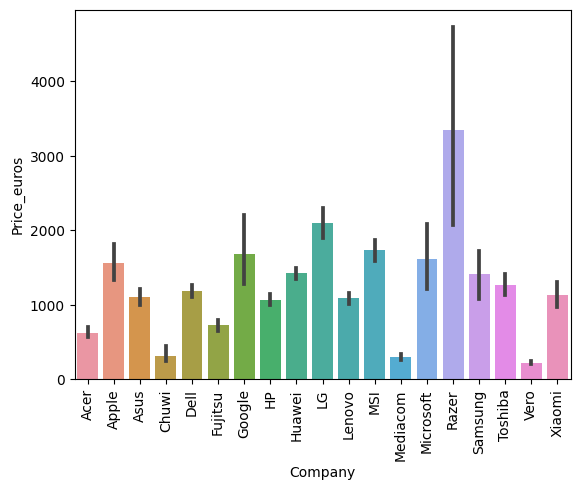

In [679]:
sns.barplot(x=df['Company'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

In [680]:
df['Company'].value_counts()

Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Vero           4
Xiaomi         4
Google         3
Fujitsu        3
Chuwi          3
LG             3
Huawei         2
Name: Company, dtype: int64

In [681]:
pd.qcut(df.groupby('Company')['Price_euros'].mean().sort_values(), q=6)


Company
Vero           (217.424, 626.776]
Mediacom       (217.424, 626.776]
Chuwi          (217.424, 626.776]
Acer           (217.424, 626.776]
Fujitsu       (626.776, 1086.384]
HP            (626.776, 1086.384]
Lenovo        (626.776, 1086.384]
Asus         (1086.384, 1186.069]
Xiaomi       (1086.384, 1186.069]
Dell         (1086.384, 1186.069]
Toshiba        (1186.069, 1424.0]
Samsung        (1186.069, 1424.0]
Huawei         (1186.069, 1424.0]
Apple          (1424.0, 1677.667]
Microsoft      (1424.0, 1677.667]
Google       (1677.667, 3346.143]
MSI          (1677.667, 3346.143]
LG           (1677.667, 3346.143]
Razer        (1677.667, 3346.143]
Name: Price_euros, dtype: category
Categories (6, interval[float64, right]): [(217.424, 626.776] < (626.776, 1086.384] <
                                           (1086.384, 1186.069] < (1186.069, 1424.0] <
                                           (1424.0, 1677.667] < (1677.667, 3346.143]]

In [682]:
company_names = {
    'Vero': 0,
    'Mediacom': 0,
    'Acer': 0,
    'Chuwi': 0,
    'Fujitsu': 1,
    'HP': 1,
    'Lenovo': 1,
    'Asus': 2,
    'Xiaomi': 2,
    'Dell': 2,
    'Toshiba': 3,
    'Samsung': 3,
    'Huawei': 3,
    'Apple': 4,
    'Microsoft': 4,
    'Google': 5,
    'MSI': 5,
    'LG': 5,
    'Razer': 5,

}
df['Company_encoded'] = df['Company'].map(company_names).astype(int)

clearing the TypeName column and creating a TypeName encoded with numeric values


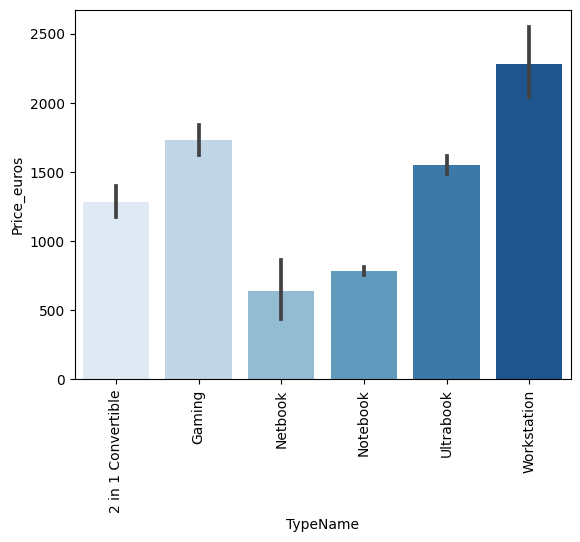

In [683]:
sns.barplot(x=df['TypeName'],y=df['Price_euros'], palette='Blues')
plt.xticks(rotation='vertical')
plt.show()

In [684]:
type_names = {
    'Netbook': 1,
    'Notebook': 2,
    '2 in 1 Convertible': 3,
    'Ultrabook': 4,
    'Gaming': 5,
    'Workstation': 6,
}
df['TypeName_encoded'] = df['TypeName'].map(type_names).astype(int)

In [685]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution_Full HD,Class_Resolution_HD,Class_Resolution_QHD,Memory_Size,Memory_Type,Memory_Size_added,Memory_Type_num,Gpu_producent,GPU_encoded,OpSys_num,Cpu_producent,CPU_encoded,Cpu_GHZ,Cpu_model,Cpu_series,Cpu_series_encoded,Company_encoded,TypeName_encoded
laptop_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0,0,1,128.0,SSD,0.0,3,Intel,2,5.0,Intel,1,2.3,Core i5,Core,9,4,4
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0,1,0,128.0,SSD,0.0,3,Intel,2,5.0,Intel,1,1.8,Core i5,Core,9,4,4
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,1,0,0,256.0,SSD,0.0,3,Intel,2,0.0,Intel,1,2.5,Core i5 7200U,Core i5,12,1,2
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0,0,1,512.0,SSD,0.0,3,AMD,0,5.0,Intel,1,2.7,Core i7,Core,9,4,4
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0,0,1,256.0,SSD,0.0,3,Intel,2,5.0,Intel,1,3.1,Core i5,Core,9,4,4


<Axes: >

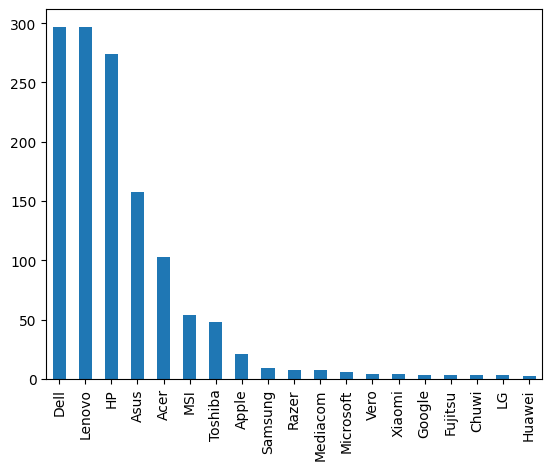

In [686]:
df['Company'].value_counts().plot(kind='bar')

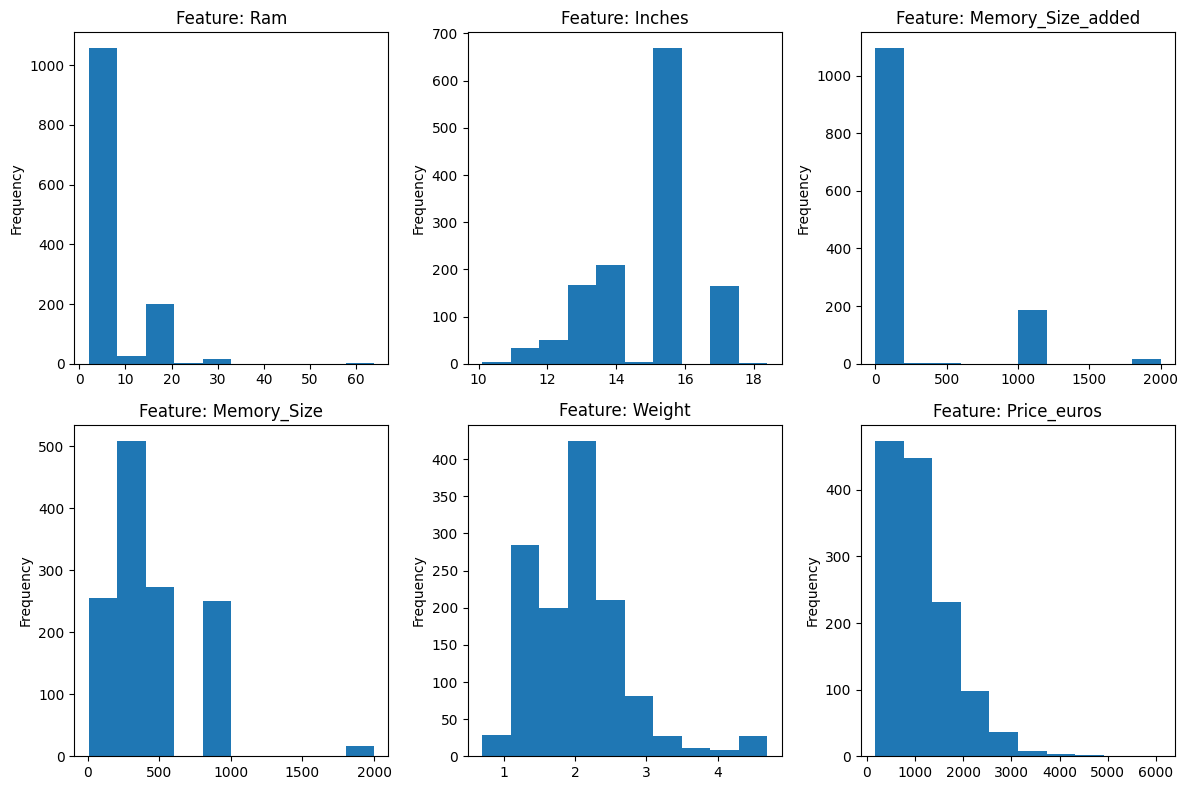

In [687]:
num_features = ['Ram', 'Inches', 'Memory_Size_added', 'Memory_Size',  'Weight', 'Price_euros']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for i, feat in enumerate(num_features):
    row, col = divmod(i, 3)  # Dzielenie indeksu na rząd i kolumnę
    df[feat].plot(kind='hist', ax=axes[row, col], bins=10)
    axes[row, col].set_title(f'Feature: {feat}')

plt.tight_layout()
plt.show()

In [688]:
df['Price_euros'].value_counts().sort_index()

174.0     1
191.9     1
196.0     1
199.0     2
202.9     1
         ..
3975.0    1
4389.0    1
4899.0    1
5499.0    1
6099.0    1
Name: Price_euros, Length: 791, dtype: int64

In [689]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1303 non-null   category
 1   Product                   1303 non-null   category
 2   TypeName                  1303 non-null   category
 3   Inches                    1303 non-null   float64 
 4   ScreenResolution          1303 non-null   category
 5   Cpu                       1303 non-null   category
 6   Ram                       1303 non-null   int64   
 7   Memory                    1303 non-null   category
 8   Gpu                       1303 non-null   category
 9   OpSys                     1303 non-null   category
 10  Weight                    1303 non-null   float64 
 11  Price_euros               1303 non-null   float64 
 12  NameResolution            1303 non-null   object  
 13  Resolution                1303 non-null   object

# Visualization of numeric columns relative to the Price_euros variable

Distribution of variables

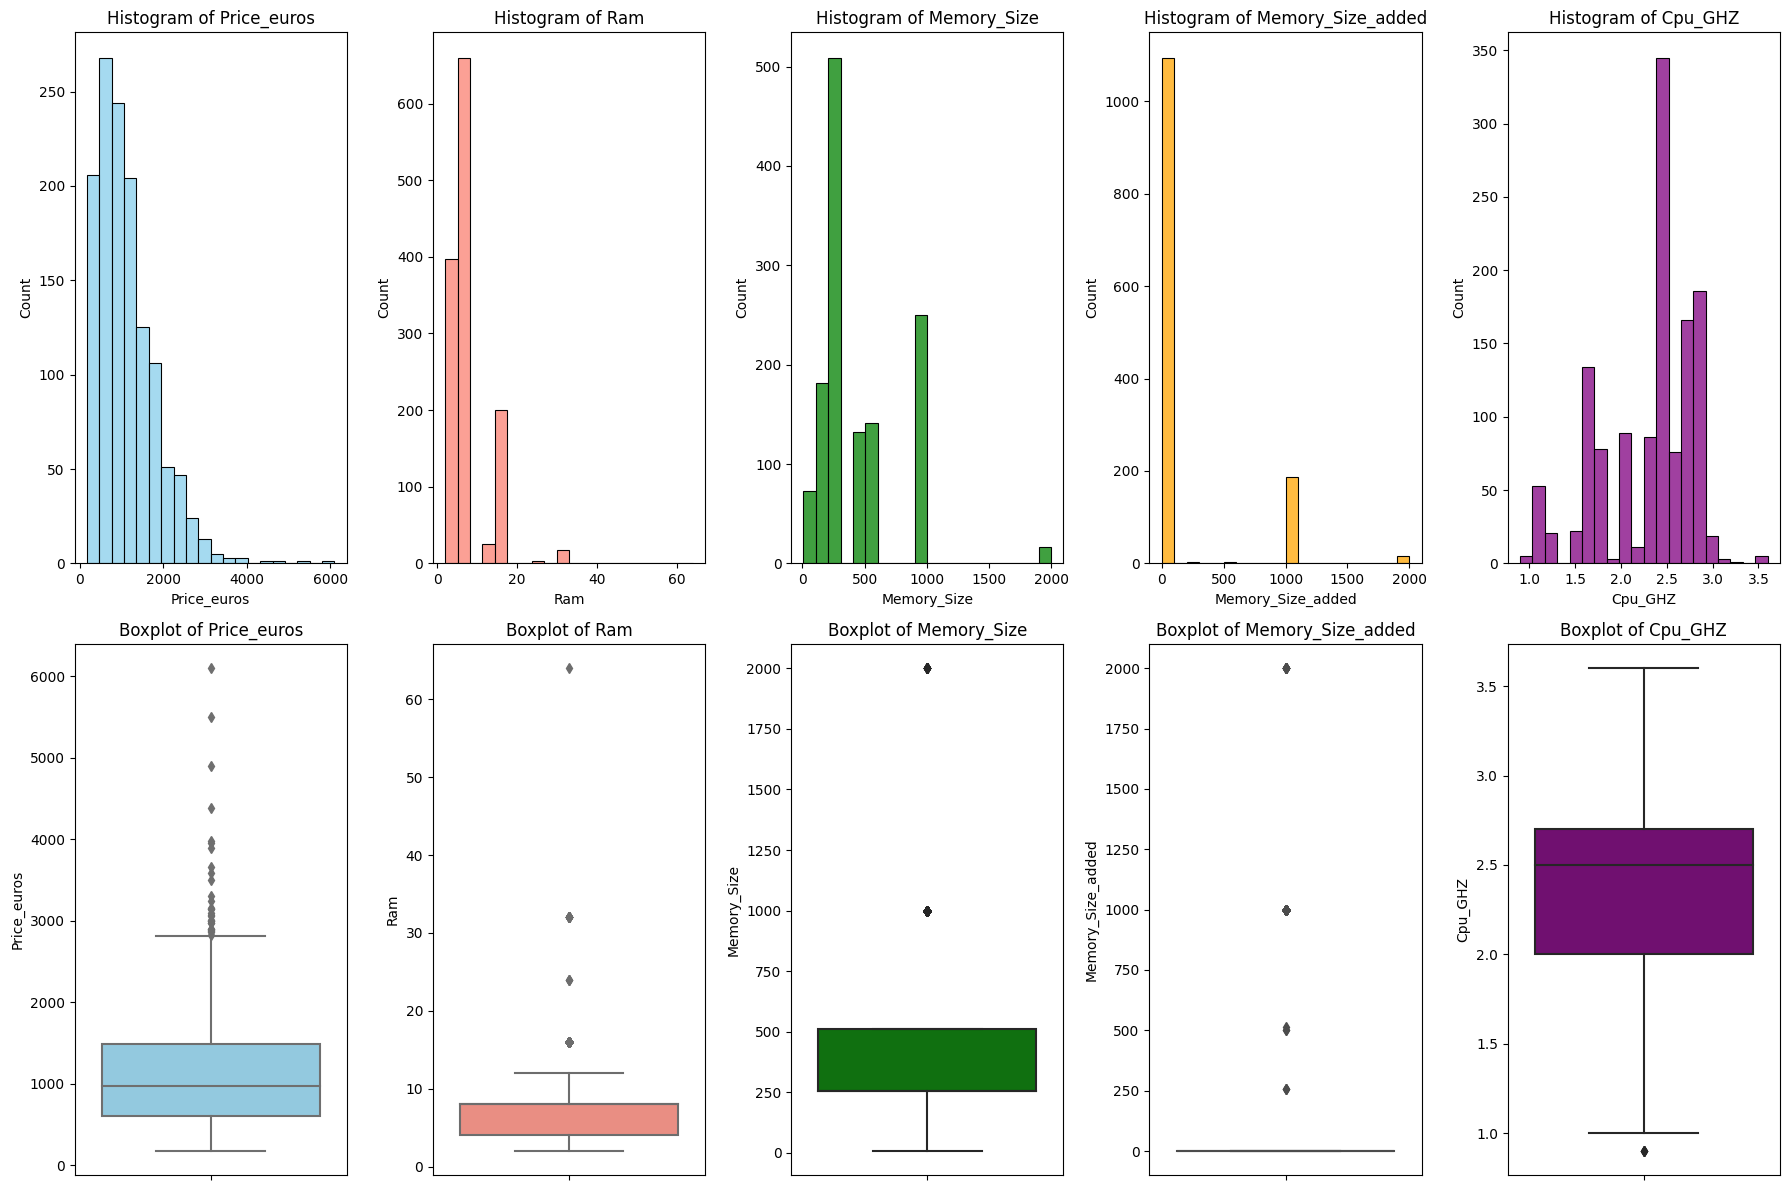

In [690]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['Price_euros', 'Ram', 'Memory_Size','Memory_Size_added', 'Cpu_GHZ']

# Dodaj kolejne kolory do listy 'palette' w przypadku, gdy liczba kolumn jest większa niż liczba kolorów w liście
palette = ["skyblue", "salmon", "green", "orange", "purple"]

fig, axs = plt.subplots(2, len(numerical_cols), figsize=(18, 12))

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=False, color=palette[i], ax=axs[0, i], bins=20)
    axs[0, i].set_title(f'Histogram of {col}')

    sns.boxplot(y=col, data=df, color=palette[i], ax=axs[1, i])
    axs[1, i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

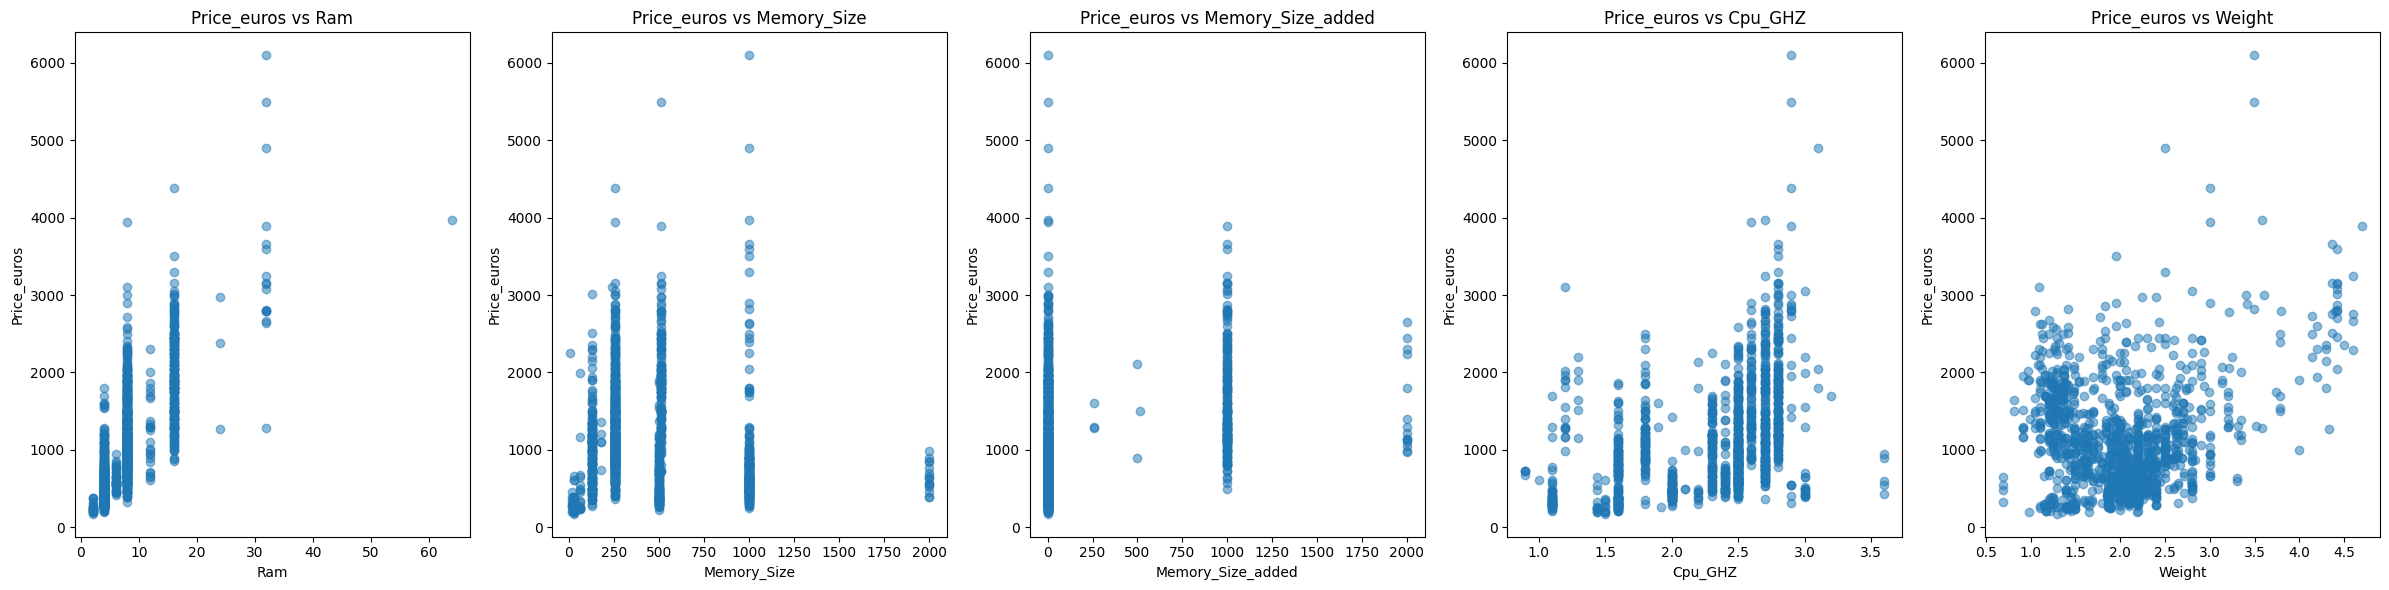

In [691]:
numerical_cols = ['Ram', 'Memory_Size', 'Memory_Size_added', 'Cpu_GHZ', 'Weight']

fig, axs = plt.subplots(1, len(numerical_cols), figsize=(24, 6))

for i, col in enumerate(numerical_cols):
    axs[i].scatter(df[col], df['Price_euros'], alpha=0.5)
    axs[i].set_title(f'Price_euros vs {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Price_euros')

plt.tight_layout()
plt.show()

Categorical variables

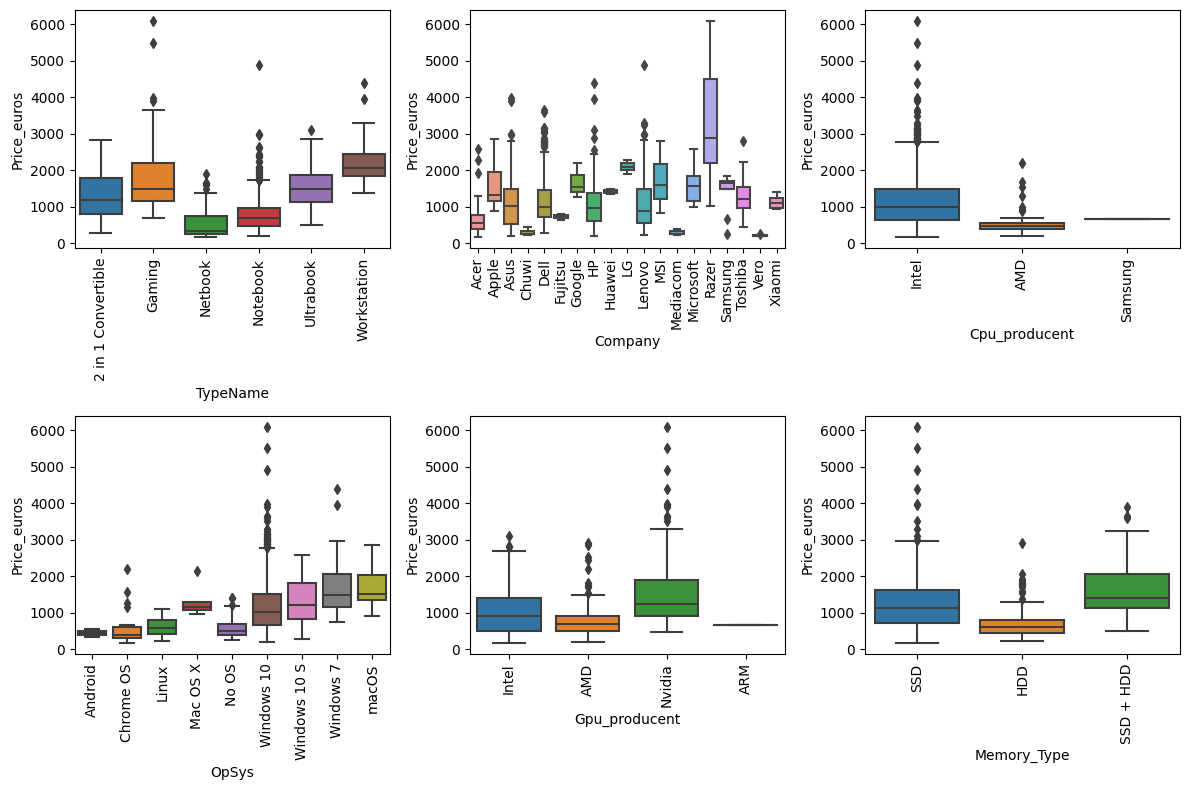

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# TypeName
plt.subplot(2, 3, 1)
sns.boxplot(x='TypeName', y='Price_euros', data=df)
plt.xticks(rotation=90)

# Company
plt.subplot(2, 3, 2)
sns.boxplot(x='Company', y='Price_euros', data=df)
plt.xticks(rotation=90)

# CPU_producent
plt.subplot(2, 3, 3)
sns.boxplot(x='Cpu_producent', y='Price_euros', data=df)
plt.xticks(rotation=90)

# OpSys
plt.subplot(2, 3, 4)
sns.boxplot(x='OpSys', y='Price_euros', data=df)
plt.xticks(rotation=90)

# GPU_producent
plt.subplot(2, 3, 5)
sns.boxplot(x='Gpu_producent', y='Price_euros', data=df)
plt.xticks(rotation=90)

# Memory_Type
plt.subplot(2, 3, 6)
sns.boxplot(x='Memory_Type', y='Price_euros', data=df)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [693]:
parquet_file_path = '/content/drive/MyDrive/Kurs/project_regression/df_before_outliers.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [3]:
parquet_file_path = '/content/drive/MyDrive/Kurs/project_regression/df_before_outliers.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

Remove outliers by company

In [755]:
# upper_outliered_companies = ['Acer', 'Asus', 'Dell', 'HP', 'Lenovo', 'Toshiba']
# lower_outliered_companies = ['Samsung']

# def remove_higher_outliers(group):
#     upper_percentile = group['Price_euros'].quantile(0.99)
#     return group[(group['Price_euros'] <= upper_percentile)]

# def remove_lower_outliers(group):
#     lower_percentile = group['Price_euros'].quantile(0.01)
#     return group[(group['Price_euros'] >= lower_percentile)]


# df[df['Company'].isin(upper_outliered_companies)] = df[df['Company'].isin(upper_outliered_companies)].groupby('Company').apply(remove_higher_outliers).reset_index(drop=True)
# df[df['Company'].isin(lower_outliered_companies)] = df[df['Company'].isin(lower_outliered_companies)].groupby('Company').apply(remove_lower_outliers).reset_index(drop=True)
# df = df.dropna()

In [724]:
# df = df.drop(df[(df['Ram'] > 32)].index)

In [531]:
# df = df.drop(df[(df['Memory_Size'] > 1999)].index)
# df = df.drop(df[(df['Memory_Size_added'] > 1999)].index)

In [5]:
df = df.drop(df[(df['Price_euros'] > 3200)].index)

In [814]:
# df = df.drop(df[(df['TypeName'] == 'Gaming') & (df['Price_euros'] > 3200)].index)
# df = df.drop(df[(df['TypeName'] == 'Workstation') & (df['Price_euros'] > 3500)].index)
# df = df.drop(df[(df['TypeName'] == 'Notebook') & (df['Price_euros'] > 3000)].index)
# df = df.drop(df[(df['OpSys'] == 'Mac OS X') & (df['Price_euros'] > 1500)].index)
# df = df.drop(df[(df['OpSys'] == 'Chrome OS') & (df['Price_euros'] > 1500)].index)


In [897]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1291 entries, 1 to 1320
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1291 non-null   category
 1   Product                   1291 non-null   category
 2   TypeName                  1291 non-null   category
 3   Inches                    1291 non-null   float64 
 4   ScreenResolution          1291 non-null   category
 5   Cpu                       1291 non-null   category
 6   Ram                       1291 non-null   int64   
 7   Memory                    1291 non-null   category
 8   Gpu                       1291 non-null   category
 9   OpSys                     1291 non-null   category
 10  Weight                    1291 non-null   float64 
 11  Price_euros               1291 non-null   float64 
 12  NameResolution            1291 non-null   object  
 13  Resolution                1291 non-null   object

Correlation matrix

In [448]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution_Full HD,Class_Resolution_HD,Class_Resolution_QHD,Memory_Size,Memory_Type,Memory_Size_added,Memory_Type_num,Gpu_producent,GPU_encoded,OpSys_num,Cpu_producent,CPU_encoded,Cpu_GHZ,Cpu_model,Cpu_series,Cpu_series_encoded,Company_encoded,TypeName_encoded
laptop_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0.0,0.0,1.0,128.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,2.3,Core i5,Core,9.0,4.0,4.0
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0.0,1.0,0.0,128.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,1.8,Core i5,Core,9.0,4.0,4.0
3,Acer,Aspire A515-51G,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,4.0,256GB SSD,Intel UHD Graphics 620,Windows 10,2.20,682.00,IPS Panel Full HD,1920x1080,1.0,0.0,0.0,256.0,SSD,0.0,3.0,Intel,2.0,4.0,Intel,1.0,1.6,Core i5 8250U,Core i5,12.0,0.0,2.0
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0.0,0.0,1.0,512.0,SSD,0.0,3.0,AMD,0.0,5.0,Intel,1.0,2.7,Core i7,Core,9.0,4.0,4.0
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0.0,0.0,1.0,256.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,3.1,Core i5,Core,9.0,4.0,4.0


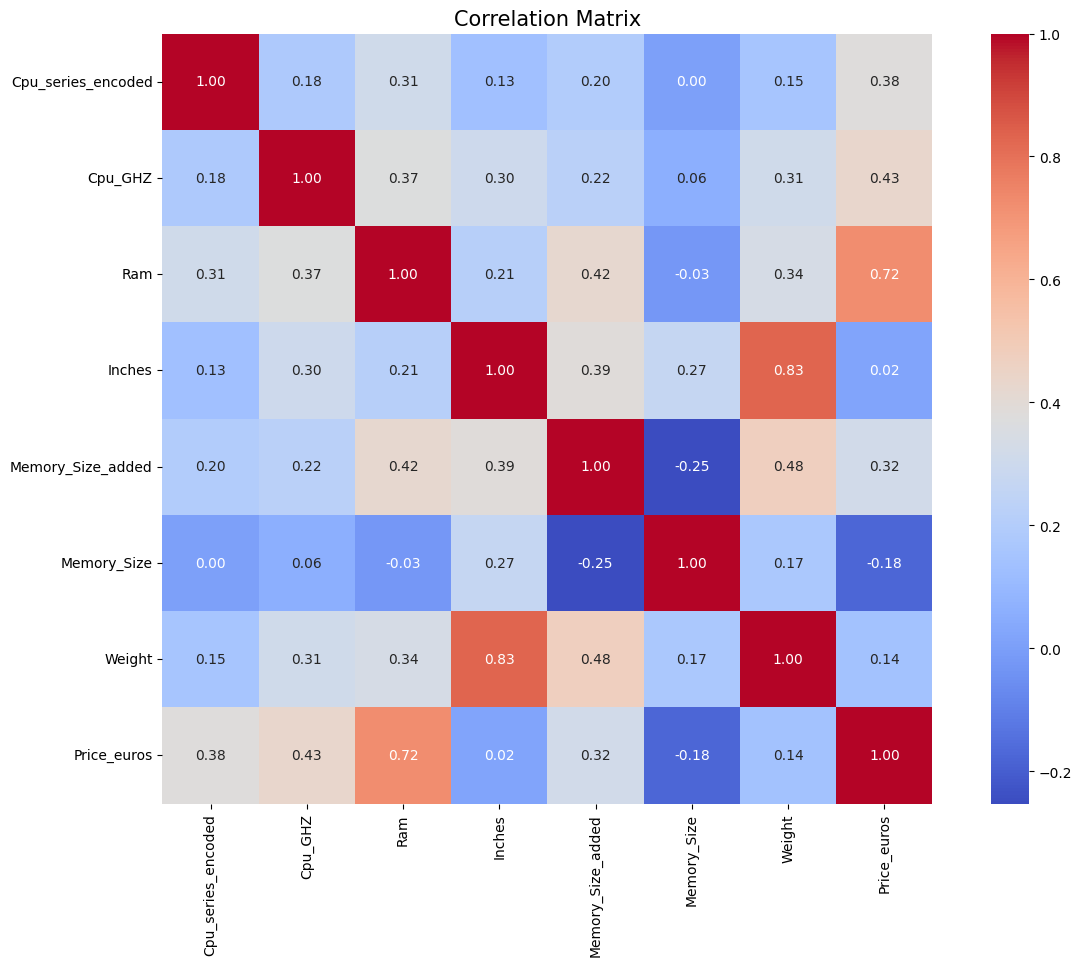

,Cpu_series_encoded,Cpu_GHZ,Ram,Inches,Memory_Size_added,Memory_Size,Weight,Price_euros
Cpu_series_encoded,1.000000,0.179235,0.312078,0.132597,0.195052,0.004849,0.154687,0.379349
Cpu_GHZ,0.179235,1.000000,0.373331,0.300922,0.223199,0.058129,0.311107,0.432015
Ram,0.312078,0.373331,1.000000,0.212981,0.422281,-0.025691,0.337484,0.723638
Inches,0.132597,0.300922,0.212981,1.000000,0.385370,0.266465,0.828934,0.019499
Memory_Size_added,0.195052,0.223199,0.422281,0.385370,1.000000,-0.252448,0.476332,0.318569
Memory_Size,0.004849,0.058129,-0.025691,0.266465,-0.252448,1.000000,0.170265,-0.176270
Weight,0.154687,0.311107,0.337484,0.828934,0.476332,0.170265,1.000000,0.143781
Price_euros,0.379349,0.432015,0.723638,0.019499,0.318569,-0.176270,0.143781,1.000000


In [7]:
columns_to_matrix = ['Cpu_series_encoded', 'Cpu_GHZ', 'Ram', 'Inches', 'Memory_Size_added', 'Memory_Size', 'Weight', 'Price_euros']
corr_df = df[columns_to_matrix].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

corr_df

In [450]:
correlation_series = corr_df[corr_df<1].stack()
sorted_correlation = correlation_series.sort_values(ascending=False)
sorted_correlation.head(10)

Inches             Weight               0.828655
Weight             Inches               0.828655
Price_euros        Ram                  0.718761
Ram                Price_euros          0.718761
Memory_Size_added  Weight               0.472592
Weight             Memory_Size_added    0.472592
Price_euros        Cpu_GHZ              0.444112
Cpu_GHZ            Price_euros          0.444112
Memory_Size_added  Ram                  0.442931
Ram                Memory_Size_added    0.442931
dtype: float64

Distribution of the Price_euros variable

In [451]:
y = df['Price_euros']
y.head()

laptop_ID
1    1339.69
2     898.94
3     682.00
4    2537.45
5    1803.60
Name: Price_euros, dtype: float64

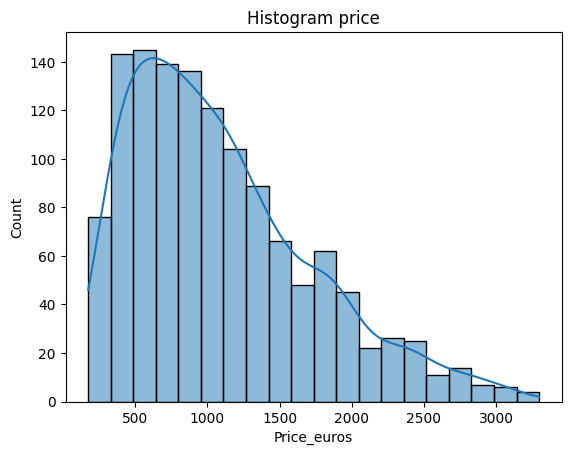

In [831]:
sns.histplot(y, kde=True)
plt.title('Histogram price')
plt.show()

In [391]:
y_log = np.log1p(df['Price_euros'])
y_log.head()

laptop_ID
1    7.200940
2    6.802328
3    6.526495
4    7.839309
5    7.498094
Name: Price_euros, dtype: float64

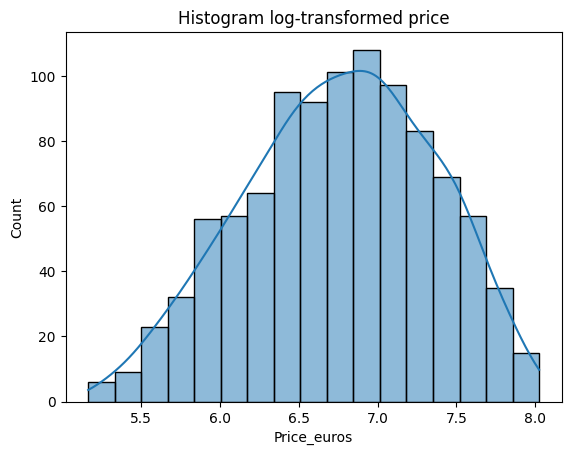

In [832]:
# Histogram y_log
sns.histplot(y_log, kde=True)
plt.title('Histogram log-transformed price')
plt.show()

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 1 to 1277
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Company                   1145 non-null   category
 1   Product                   1145 non-null   category
 2   TypeName                  1145 non-null   category
 3   Inches                    1145 non-null   float64 
 4   ScreenResolution          1145 non-null   category
 5   Cpu                       1145 non-null   category
 6   Ram                       1145 non-null   float64 
 7   Memory                    1145 non-null   category
 8   Gpu                       1145 non-null   category
 9   OpSys                     1145 non-null   category
 10  Weight                    1145 non-null   float64 
 11  Price_euros               1145 non-null   float64 
 12  NameResolution            1145 non-null   object  
 13  Resolution                1145 non-null   object

In [455]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,NameResolution,Resolution,Class_Resolution_Full HD,Class_Resolution_HD,Class_Resolution_QHD,Memory_Size,Memory_Type,Memory_Size_added,Memory_Type_num,Gpu_producent,GPU_encoded,OpSys_num,Cpu_producent,CPU_encoded,Cpu_GHZ,Cpu_model,Cpu_series,Cpu_series_encoded,Company_encoded,TypeName_encoded
laptop_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0.0,0.0,1.0,128.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,2.3,Core i5,Core,9.0,4.0,4.0
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0.0,1.0,0.0,128.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,1.8,Core i5,Core,9.0,4.0,4.0
3,Acer,Aspire A515-51G,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,4.0,256GB SSD,Intel UHD Graphics 620,Windows 10,2.20,682.00,IPS Panel Full HD,1920x1080,1.0,0.0,0.0,256.0,SSD,0.0,3.0,Intel,2.0,4.0,Intel,1.0,1.6,Core i5 8250U,Core i5,12.0,0.0,2.0
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0.0,0.0,1.0,512.0,SSD,0.0,3.0,AMD,0.0,5.0,Intel,1.0,2.7,Core i7,Core,9.0,4.0,4.0
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0.0,0.0,1.0,256.0,SSD,0.0,3.0,Intel,2.0,5.0,Intel,1.0,3.1,Core i5,Core,9.0,4.0,4.0


In [63]:
parquet_file_path = '/content/drive/MyDrive/Kurs/project_regression/df_cleaned.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [64]:
parquet_file_path = '/content/drive/MyDrive/Kurs/project_regression/df_cleaned.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [457]:
columns_to_matrix

['Cpu_series_encoded',
 'Cpu_GHZ',
 'Ram',
 'Inches',
 'Memory_Size_added',
 'Memory_Size',
 'Weight',
 'Price_euros']

In [8]:
labels_to_model = columns_to_matrix + ['TypeName_encoded', 'Company_encoded', 'CPU_encoded', 'OpSys_num', 'GPU_encoded', 'Memory_Type_num', 'Class_Resolution_QHD', 'Class_Resolution_HD', 'Class_Resolution_Full HD']

In [9]:
labels_to_model.remove('Price_euros')
labels_to_model

['Cpu_series_encoded',
 'Cpu_GHZ',
 'Ram',
 'Inches',
 'Memory_Size_added',
 'Memory_Size',
 'Weight',
 'TypeName_encoded',
 'Company_encoded',
 'CPU_encoded',
 'OpSys_num',
 'GPU_encoded',
 'Memory_Type_num',
 'Class_Resolution_QHD',
 'Class_Resolution_HD',
 'Class_Resolution_Full HD']

# Models

In [37]:
X = df[labels_to_model]
# y = np.log(df['Price_euros'])
y = df['Price_euros']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Polynomial regression model

In [39]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Ram', 'Weight', 'Memory_Size', 'Memory_Size_added', 'Cpu_GHZ']
scaler = StandardScaler()

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [40]:
poly_features = PolynomialFeatures(degree=2)

In [41]:
poly_features.fit(X_train)

PolynomialFeatures()

In [42]:
X_train_poly = poly_features.transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [43]:
modelpoly = Ridge(alpha=0.1)
modelpoly.fit(X_train_poly, y_train)

Ridge(alpha=0.1)

In [44]:
y_pred_poly = modelpoly.predict(X_test_poly)

In [45]:
y_pred_polytrain = modelpoly.predict(X_train_poly)

In [46]:
# r2_poly = r2_score(np.expm1(y_test),np.expm1(y_pred_poly))
r2_poly = r2_score(y_test,y_pred_poly)

r2_poly

0.755939293836234

In [47]:
# r2_polytrain = r2_score(np.expm1(y_train),np.expm1(y_pred_polytrain))
r2_polytrain = r2_score(y_train,y_pred_polytrain)

r2_polytrain

0.8516909696958624

In [48]:
# mse_poly = mean_squared_error(np.expm1(y_test),np.expm1(y_pred_poly))
mse_poly = mean_squared_error(y_test,y_pred_poly)

mse_poly

93000.31862027559

In [49]:
rmse_poly = np.sqrt(mse_poly)
rmse_poly

304.95953603761205

In [50]:
coefficients_poly = modelpoly.coef_
coefficients_poly

array([ 0.00000000e+00,  2.48265069e+02,  1.27540763e+02,  3.67174991e+02,
       -4.67735065e+02, -2.48043319e+02, -5.10101501e+02,  8.48728988e+02,
       -3.31070210e+02,  4.08772872e+01, -1.43180117e+02,  2.05741198e+02,
       -2.03745701e+02,  3.87158712e+02, -4.18449068e+02,  8.30929514e+02,
        1.45812937e+02, -3.73954711e+00,  1.49566785e+01,  3.95236997e+00,
       -9.87041262e+00,  4.97225294e-01, -1.24143553e+00,  6.57516959e+00,
       -5.97201293e-01,  3.86511219e+00,  4.13811795e+01,  7.14240485e-01,
        1.59158903e+01, -7.18339228e+00, -9.44137463e+01, -3.24891952e+01,
        5.30781419e+00,  2.74012287e+01,  3.10460219e+01, -4.90110925e+01,
       -1.75838385e+01, -1.68509504e+01,  1.00815485e+02,  3.35805452e+01,
       -2.69273636e+01,  1.86210062e+01,  1.22447622e+01,  1.72573250e+01,
        9.79951903e+00,  3.64079062e+02,  4.48067715e+02,  3.91163964e+02,
       -1.97837841e+01, -1.33216023e+01, -2.86389241e+01, -4.06417378e+01,
        1.42612101e+01, -

In [51]:
intercept_poly = modelpoly.intercept_
intercept_poly

3097.067681007873

## Decission tree model

In [20]:
X = df[labels_to_model]
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [21]:
def objective(trial):
    # Definiowanie przestrzeni hiperparametrów
    max_depth = trial.suggest_categorical('max_depth', [10, 11, 12, 13, 14, 15, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 3, 4, 5, 7, 8, 9, 10, 11, 12])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 3, 4, 5, 6, 8, 10])

    # Tworzenie modelu drzewa decyzyjnego do regresji z hiperparametrami
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Trenowanie modelu
    model.fit(X_train, y_train)

    # Prognozowanie na danych testowych
    y_pred = model.predict(X_test)

    # Obliczanie błędu średniokwadratowego (MSE) jako miary jakości
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

[I 2023-10-14 13:24:39,879] A new study created in memory with name: no-name-1ecbc1e9-712f-4e78-a5f6-85bbd64aafab
[I 2023-10-14 13:24:39,897] Trial 0 finished with value: 105967.91220203583 and parameters: {'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 105967.91220203583.
[I 2023-10-14 13:24:39,916] Trial 1 finished with value: 108551.43848823654 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 105967.91220203583.
[I 2023-10-14 13:24:39,930] Trial 2 finished with value: 91151.05052874834 and parameters: {'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 2 with value: 91151.05052874834.
[I 2023-10-14 13:24:39,945] Trial 3 finished with value: 91151.05052874834 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 2 with value: 91151.05052874834.
[I 2023-10-14 13:24:39,959] Trial 4 finished with value: 10596

In [23]:
best_params = study.best_params

In [24]:
best_model_tree = DecisionTreeRegressor(random_state=42, **best_params)

In [25]:
best_model_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=11,
                      random_state=42)

In [26]:
best_model_tree.get_depth()

10

In [27]:
best_model_tree.get_n_leaves()

122

In [28]:
best_model_tree.feature_importances_

array([2.39753589e-02, 4.96961331e-02, 2.72564203e-01, 3.32159204e-02,
       2.16030897e-03, 1.03201496e-02, 9.07458268e-02, 4.53084990e-01,
       9.20097731e-03, 2.37807107e-04, 2.25663387e-03, 3.29292067e-03,
       3.13712782e-02, 2.17405207e-03, 3.90660951e-03, 1.17968296e-02])

In [29]:
pd.DataFrame({'Feature': labels_to_model, 'Importance': best_model_tree.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
7,TypeName_encoded,0.453085
2,Ram,0.272564
6,Weight,0.090746
1,Cpu_GHZ,0.049696
3,Inches,0.033216
12,Memory_Type_num,0.031371
0,Cpu_series_encoded,0.023975
15,Class_Resolution_Full HD,0.011797
5,Memory_Size,0.010320
8,Company_encoded,0.009201


In [30]:
y_pred_train = best_model_tree.predict(X_train)
y_pred_test = best_model_tree.predict(X_test)

In [31]:
r2_tree = r2_score(y_train,y_pred_train)
print('r2 score for training data: ', r2_score(y_train,y_pred_train))

r2 score for training data:  0.8659109372271308


In [32]:
rmse_tree = mean_squared_error(y_test, y_pred_test, squared=False)
print('Root mean squared error: ', np.sqrt(mean_squared_error(y_test,y_pred_test)))

Root mean squared error:  290.33615972873486


## Random Forest Regression

In [33]:
X = df[labels_to_model]
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [34]:
rf_model = RandomForestRegressor(n_estimators=100, min_samples_split= 5, min_samples_leaf= 2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                      random_state=42)

In [35]:
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

In [36]:
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_train, y_pred_train)
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {np.sqrt(mse_rf)}")
print(f"R2 score: {r2_rf}")

Mean Squared Error: 73141.8643819279
Root Mean Squared Error: 270.4475261153777
R2 score: 0.9377423849767255


## Model SVR

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVR
# import scipy.stats as stats
# import numpy as np

# param_dist = {
#     'C': stats.uniform(15, 1000),
#     'kernel': ['linear'],
#     'gamma': stats.loguniform(0.001, 0.05)
# }

# svr = SVR()

# # Utwórz obiekt Random Search
# random_search = RandomizedSearchCV(svr, param_dist, n_iter=5, cv=4, scoring='neg_mean_squared_error', random_state=42)

In [ ]:
# # Wyszukaj najlepsze parametry na podstawie dostępnych danych
# random_search.fit(X_train, y_train)

In [ ]:
# best_params = random_search.best_params_

In [ ]:
# best_params

In [13]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Ram', 'Weight', 'Memory_Size', 'Memory_Size_added', 'Cpu_GHZ']
scaler = StandardScaler()

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [14]:
# best_svr = SVR(**best_params)
best_svr = SVR(C=1000, kernel='linear', gamma=0.05)
best_svr.fit(X_train, y_train)

SVR(C=1000, gamma=0.05, kernel='linear')

In [15]:
y_pred_train = best_svr.predict(X_train)
y_pred_test = best_svr.predict(X_test)

In [17]:
mse_svr = mean_squared_error(y_test, y_pred_test)
r2_svr = r2_score(y_train, y_pred_train)
rmse_svr = mean_squared_error(y_test, y_pred_test, squared=False)


print(f"Mean Squared Error: {mse_svr}")
print(f"Root Mean Squared Error: {np.sqrt(mse_svr)}")
print(f"R2 score: {r2_svr}")

Mean Squared Error: 96690.81067638064
Root Mean Squared Error: 310.95146032199403
R2 score: 0.7102917953405053


## XGBoost

In [52]:
X = df[labels_to_model]
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [53]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    }

    xgb_model = xgboost.XGBRegressor(**params, random_state=42)

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [54]:
study = optuna.create_study(direction='minimize')


study.optimize(objective, n_trials=100)

[I 2023-10-14 13:25:24,747] A new study created in memory with name: no-name-e726623e-ead9-4c9b-a430-52423329f6d3
[I 2023-10-14 13:25:24,897] Trial 0 finished with value: 273.3412208365537 and parameters: {'learning_rate': 0.1073410163875702, 'n_estimators': 100, 'max_depth': 15, 'min_child_weight': 6, 'gamma': 0.10714183346373667}. Best is trial 0 with value: 273.3412208365537.
[I 2023-10-14 13:25:25,022] Trial 1 finished with value: 328.00772390100934 and parameters: {'learning_rate': 0.026323414613924626, 'n_estimators': 58, 'max_depth': 14, 'min_child_weight': 2, 'gamma': 0.008320445473816076}. Best is trial 0 with value: 273.3412208365537.
[I 2023-10-14 13:25:25,123] Trial 2 finished with value: 266.00959809946954 and parameters: {'learning_rate': 0.037379932792680676, 'n_estimators': 94, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.0002229256825667366}. Best is trial 2 with value: 266.00959809946954.
[I 2023-10-14 13:25:25,203] Trial 3 finished with value: 275.15260770163553

In [55]:
best_params = study.best_params
print("Best params:")
print(study.best_params)
print("Best RMSE:", study.best_value)

Best params:
{'learning_rate': 0.2953743014460803, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.2590295607541633}
Best RMSE: 244.23528873400352


In [56]:
xgb_model = xgboost.XGBRegressor(**best_params, random_state=42)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2590295607541633, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2953743014460803,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [60]:
mse = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_train, y_pred_train)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse_xgb}")
print(f"R2 score: {r2_xgb}")

Mean Squared Error: 59650.87626298206
Root Mean Squared Error: 244.23528873400352
R2 score: 0.9168824825742096


# Summary



In [61]:
print('r2 score - Decission Tree: ', r2_tree)
print('r2 score - poly regression(reg. Ridge): ', r2_poly)
print('r2 score - random forest regression: ', r2_rf)
print('r2 score - SVR: ', r2_svr)
print('r2 score - SVR: ', r2_xgb)


r2 score - Decission Tree:  0.8659109372271308
r2 score - poly regression(reg. Ridge):  0.755939293836234
r2 score - random forest regression:  0.9377423849767255
r2 score - SVR:  0.7102917953405053
r2 score - SVR:  0.9168824825742096


In [62]:
print('RMSE score - Decission Tree: ', rmse_tree)
print('RMSE score - poly regression(reg. Ridge): ', rmse_poly)
print('RMSE score - random forest regression: ', rmse_rf)
print('RMSE score - SVR: ', rmse_svr)
print('RMSE score - SVR: ', rmse_xgb)

RMSE score - Decission Tree:  290.33615972873486
RMSE score - poly regression(reg. Ridge):  304.95953603761205
RMSE score - random forest regression:  270.4475261153777
RMSE score - SVR:  310.95146032199403
RMSE score - SVR:  244.23528873400352


## **The best model is XGBoost.**